- 앞서 `notebooks/model_training/02_re_drowsinesss_cls(CNN).ipynb` 파일에서 tuner를 돌릴 때 fit한 결과를 history로 바인딩하지 않아 plot을 따로 찍을 수 없었음
- 그래서 `notebooks/model_pred/02_drowsiness_cls(CNN).ipynb` 파일에서 best param으로 돌렸으나 최적의 성능이 나오지 못함
- 따라서 `notebooks/model_training/02_re_drowsinesss_cls(CNN).ipynb` 파일에서 나온 `src/models/02_Basic_Model/best_model.keras`를 사용하기로 함  
  단, history는 어쩔 수 없이 포기  

In [7]:
import numpy as np
import random
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"]="Malgun Gothic"
plt.rcParams["axes.unicode_minus"]=False

In [2]:
IMG_SIZE=86
BATCH_SIZE=16
SEED=42
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

# validation only
datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator=datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 9600 images belonging to 2 classes.


In [3]:
model=load_model("../../src/models/02_Basic_Model/best_model.keras")
model.summary()

d:\Anaconda\envs\firstENV\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 84, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 96)     │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 40, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,458,405 (28.45 MB)

 Trainable params: 2,486,049 (9.48 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 4,972,100 (18.97 MB)

In [10]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/fianl_classification_report.txt", "w") as f:
    f.write(report)

d:\Anaconda\envs\firstENV\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


              precision    recall  f1-score   support

      closed       0.92      1.00      0.95      4800
        open       1.00      0.91      0.95      4800

    accuracy                           0.95      9600
   macro avg       0.96      0.95      0.95      9600
weighted avg       0.96      0.95      0.95      9600



C:\Users\user\AppData\Local\Temp\ipykernel_37148\2625310371.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label=class_names[int(y_pred[idx])]  # pred


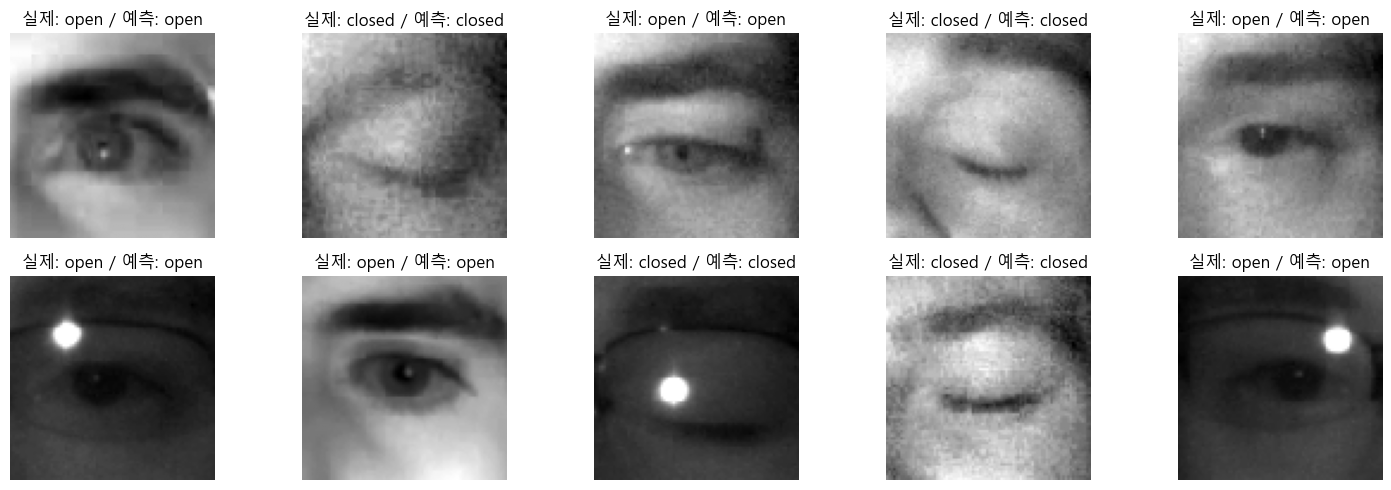

In [8]:
class_names=list(val_generator.class_indices.keys())  # closed, open
indices=random.sample(range(len(y_true)), 10)  # 전체 val 데이터 중 10개 무작위 인덱스 선택

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):  # 10개 인덱스에 대해 하나씩 처리
    batch_idx=idx // BATCH_SIZE  # 인덱스가 몇 번째 배치에 속해 있는지 계산
    offset=idx % BATCH_SIZE  # 해당 배치 내에서의 위치 계산

    val_generator.reset()  # generator 처음부터 리셋해서 배치 인덱스까지 이동
    for _ in range(batch_idx+1):  # 항상 같은 순서로 시작하기 위해 초기화
        images, _=next(val_generator)  # 원하는 배치까지 이동

    img=images[offset].squeeze()  # 해당 배치에서 원하는 이미지 하나 꺼내기(squeeze: 86, 86, 1 -> 86, 86)
    true_label=class_names[int(y_true[idx])]  # real
    pred_label=class_names[int(y_pred[idx])]  # pred

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"실제: {true_label} / 예측: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

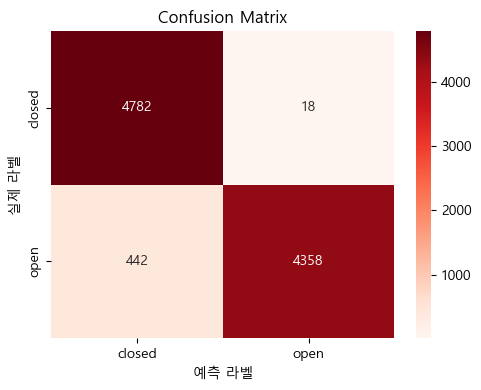

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬
cm=confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("예측 라벨")
plt.ylabel("실제 라벨")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../../results/images/fianl_confusion_matrix.png")
plt.show()